In [1]:
import os.path as op
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np


In [5]:
sub_ids = [
            'prex010'
           ]
data_path = '.\data\\1raw_rename\\'

Opening raw data file .\data\1raw_rename\prex010.fif...


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_9968/3811079624.py:9: RuntimeWarning: This filename (.\data\1raw_rename\prex010.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)


Isotrak not found
    Range : 0 ... 1182419 =      0.000 ...  2364.838 secs
Ready.
Reading 0 ... 1182419  =      0.000 ...  2364.838 secs...


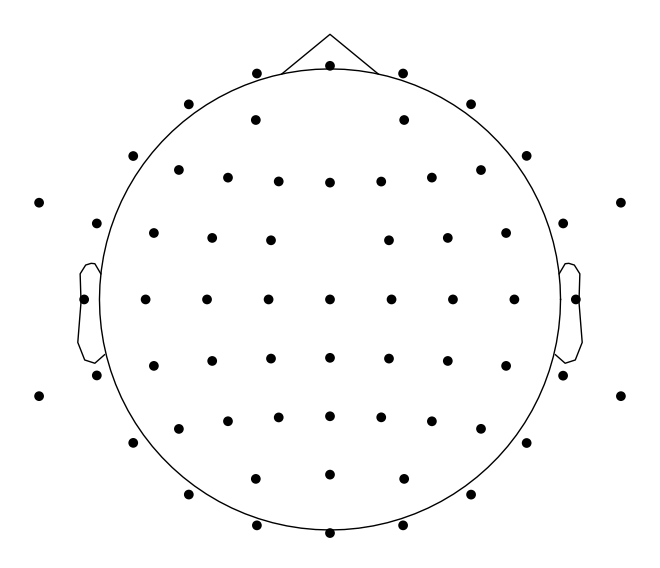

In [6]:
#把数据一次性全部读入，但是次序……
mname = 'E:\Python LYW\RSA\spaced_learning\pre5\preprocessing\pre5_chan.loc'
# 这里竟然用的是同样的size，这样也太不准了。
mantage = mne.channels.read_custom_montage(mname, head_size=0.095)

sub_id = sub_ids[0]
fname = op.join(data_path + sub_id + '.fif')

raw = mne.io.read_raw_fif(fname, preload=True, verbose=None)

raw.plot(n_channels = 50, duration =40, scalings=40e-6, remove_dc = True)
raw.set_montage(montage=mantage)
raw.plot_sensors()
raw.set_channel_types(mapping={'VEOG':'eog'})
raw.plot_sensors()

Channels marked as bad: none
Channels marked as bad: none
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



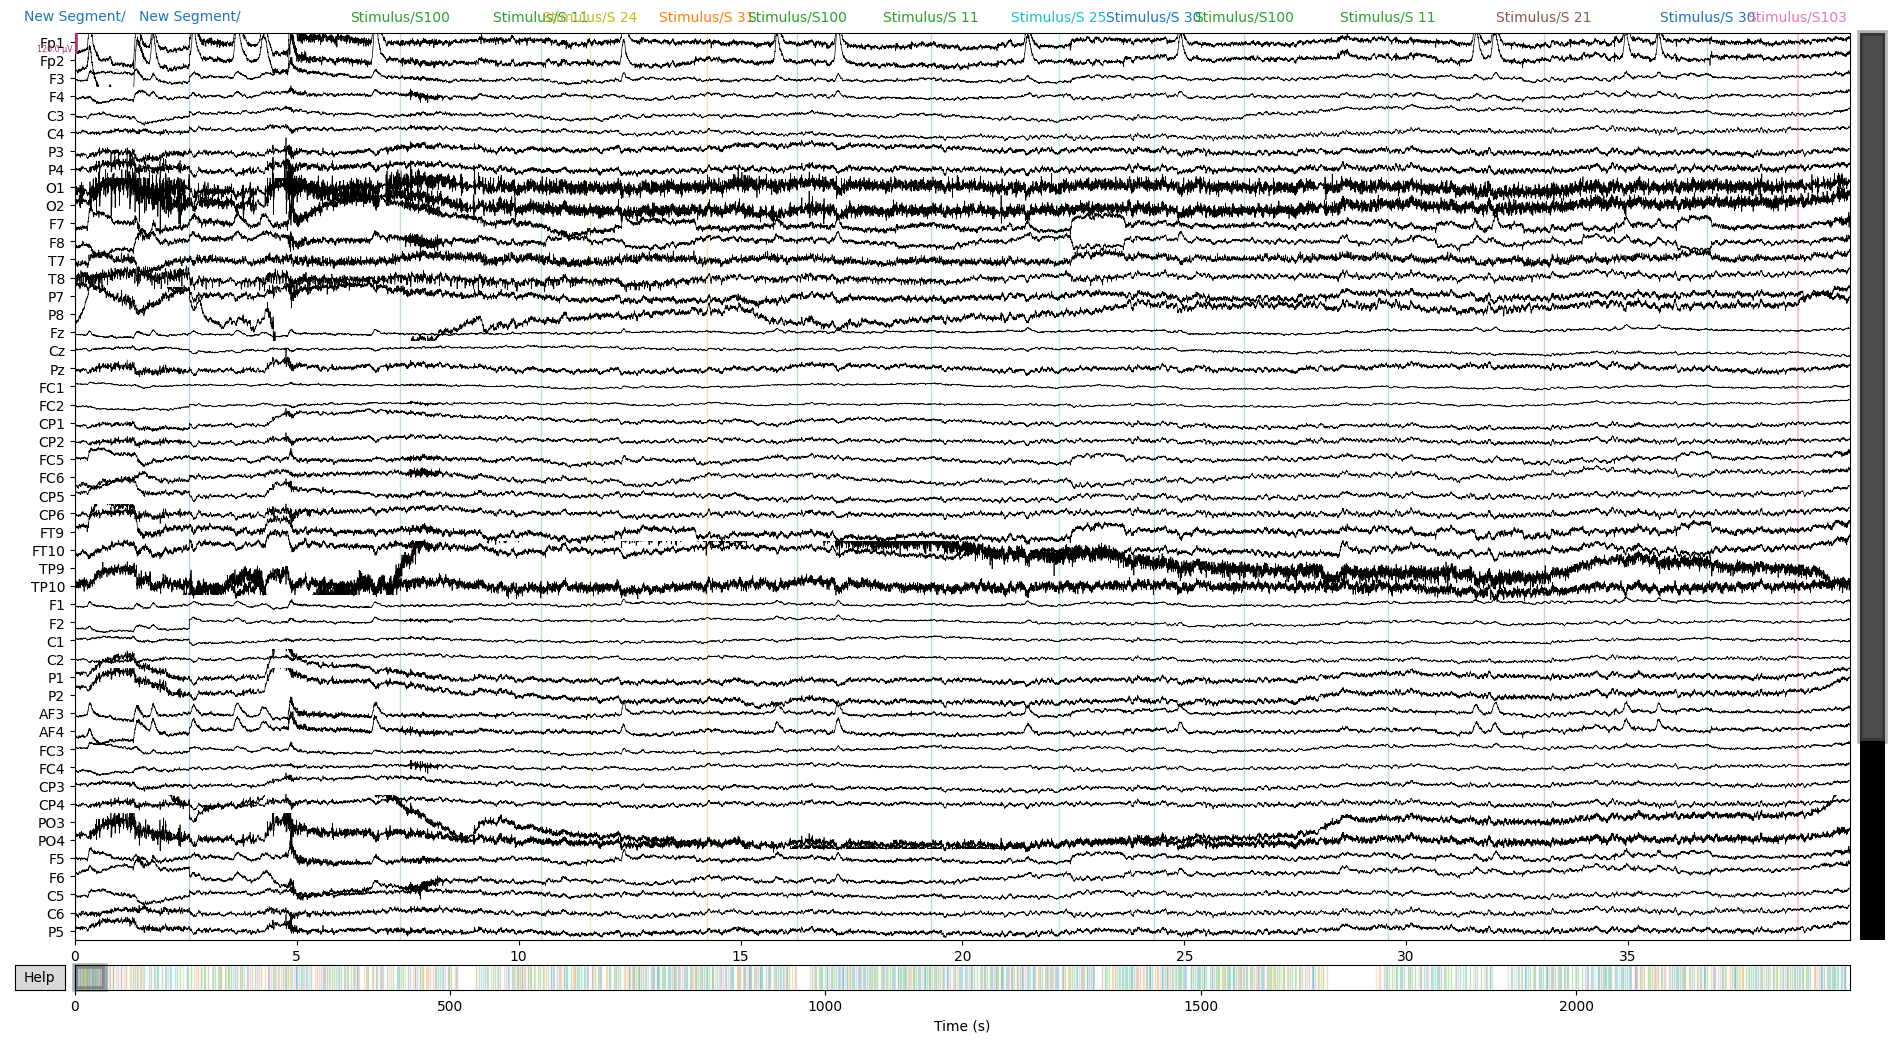

In [7]:
#找出坏导
%matplotlib qt
raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,
                 highpass=0.1, lowpass=30)
raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)
# raw.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True, butterfly = True)


In [16]:

print(raw.info['bads'])
save_path_bad = '.\data\\2raw_bad\\'
raw.save(save_path_bad + sub_id + '.fif', overwrite=True)


[]
Overwriting existing file.
Writing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_1788/489436741.py:3: RuntimeWarning: This filename (E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path_bad + sub_id + '.fif', overwrite=True)


Closing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif
[done]
[]
Overwriting existing file.
Writing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_1788/489436741.py:3: RuntimeWarning: This filename (E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path_bad + sub_id + '.fif', overwrite=True)


Closing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\2raw_bad\prex051.fif
[done]


In [8]:
#插值
original_bads = deepcopy(raw.info['bads'])
print(raw.info['bads'])
#截取一部分作图
# raw.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)
# How interpolation works¶根据手册，是根据topo位置来插值？所以需要location
raw_interp = raw.copy().interpolate_bads(reset_bads=True)
print(raw.info['bads'])
# raw_interp.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6, remove_dc = True,highpass=1,lowpass=40)

#滤波
# raw_interp.copy().plot_psd(area_mode='range', average=False)
raw_middlepass = raw_interp.copy().filter(0.1, 30.)
sample_rate=500
freqs = np.arange(50, sample_rate / 2, 50)
raw_middlepass_notch = raw_middlepass.copy().notch_filter(freqs=freqs)
# raw_middlepass_notch.copy().plot_psd(area_mode='range', average=False)

#重参考
#需要搞清楚到底有没有把eog channel一起算进去。
# raw_middlepass_notch.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)
raw_rerefer = raw_middlepass_notch.copy().set_eeg_reference(ref_channels='average')
# raw_rerefer.copy().crop(tmin=0,tmax=100).plot(n_channels = 50, duration =40, scalings=40e-6,remove_dc = True,highpass=1,lowpass=40)

#保存,在ICA之前
print(raw_rerefer.info['custom_ref_applied'])
save_path_bad = '.\data\\3raw_rereference\\'
raw_rerefer.save(save_path_bad + sub_id + '.fif', overwrite=True)

[]


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_9968/1409332871.py:7: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_interp = raw.copy().interpolate_bads(reset_bads=True)


[]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)

EEG channel type selected for re-referencing
Applying 

C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_9968/1409332871.py:28: RuntimeWarning: This filename (E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\3raw_rereference\prex010.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_rerefer.save(save_path_bad + sub_id + '.fif', overwrite=True)


Overwriting existing file.
Writing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\3raw_rereference\prex010.fif
Closing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\3raw_rereference\prex010.fif
[done]


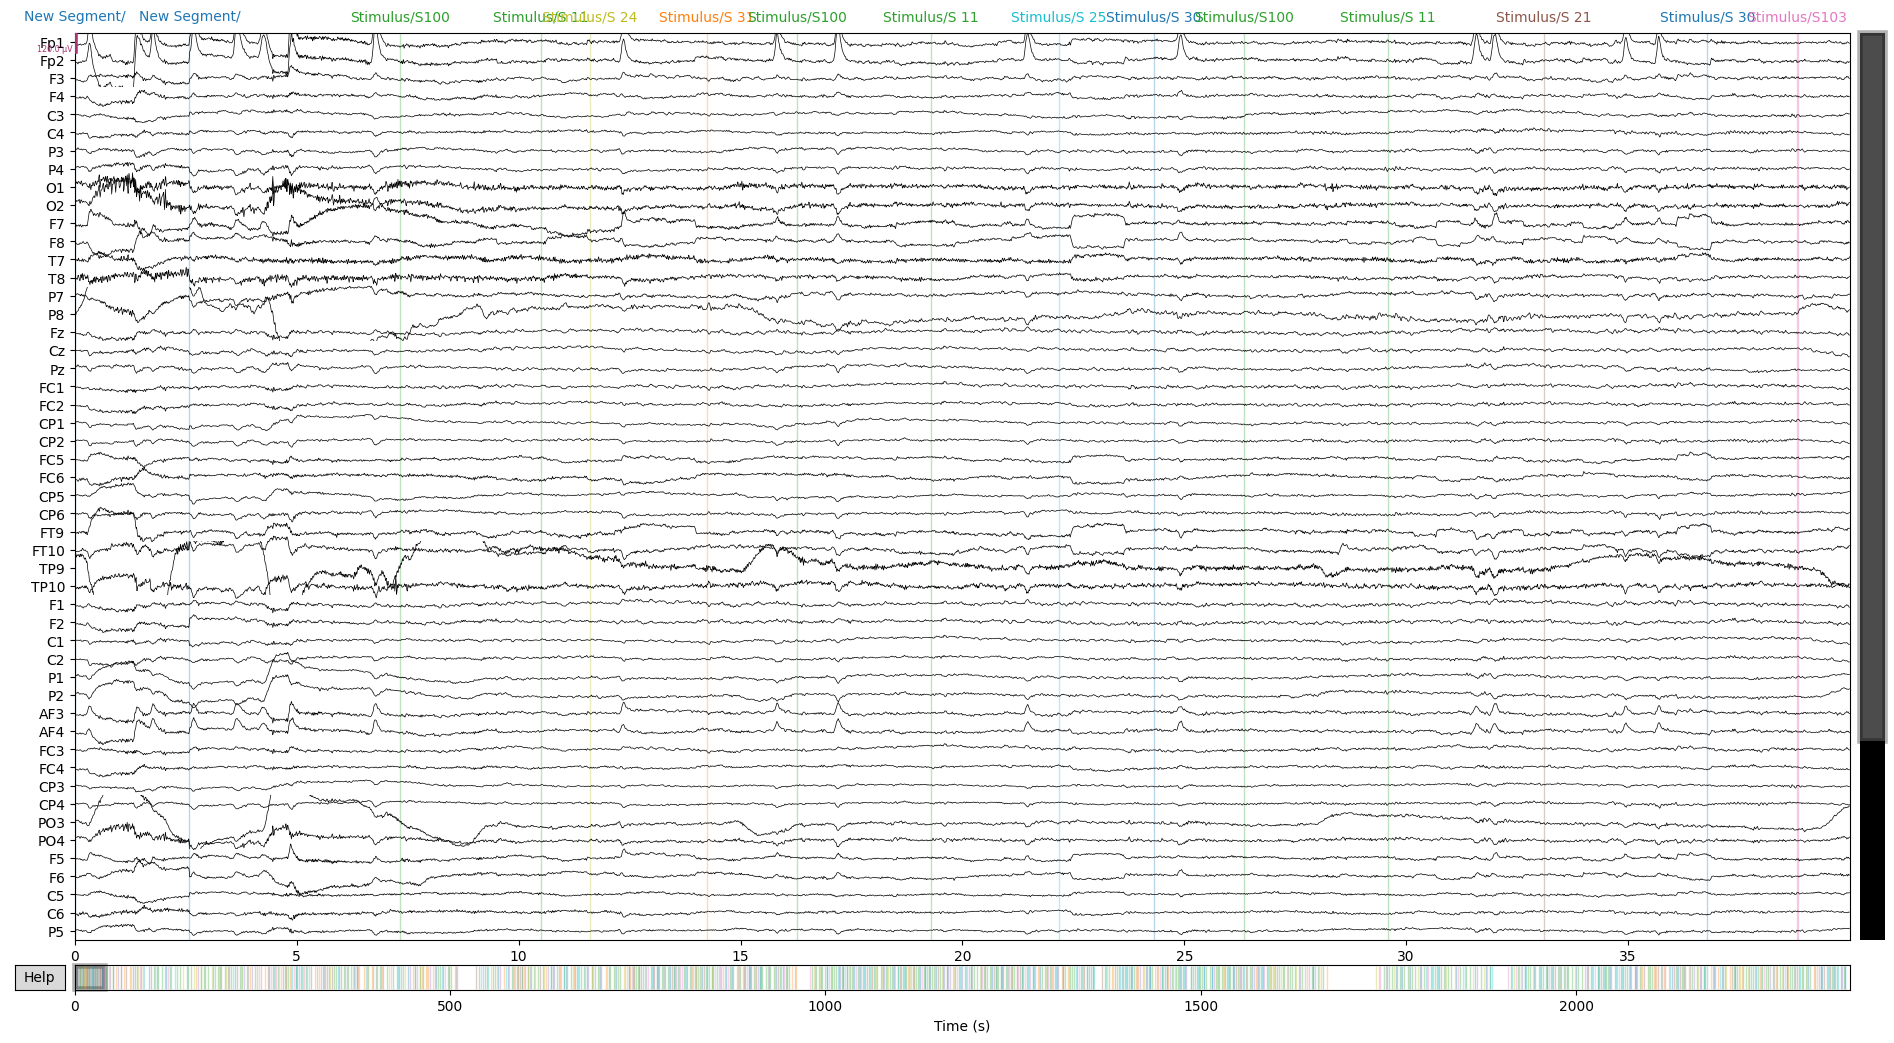

In [9]:
raw_rerefer.plot(n_channels = 50, duration =40, scalings=60e-6, remove_dc = True,)

In [10]:
import time
time_start=time.time()
# ICA
raw_filt = raw_rerefer.copy()
raw_filt.load_data().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=50, random_state=97)
#训练，但是并没有删除
ica.fit(raw_filt)
#计时
time_end=time.time()
print('time cost',time_end-time_start,'s')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_9968/3895937857.py:6: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=50, random_state=97)


Selecting by number: 50 components
Fitting ICA took 120.6s.
time cost 125.76537895202637 s


In [13]:
#有多种选择，自动，手动。找出eog component
# eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold=3.0, ch_name='Fp2')#0 7数据眼电有问题
eog_inds, eog_scores = ica.find_bads_eog(raw_filt, threshold=3.0)
#参考一下机器
ica.plot_scores(eog_scores)
#但是要自己检查一下,有问题就手动修改eog_ins
ica.plot_components(inst=raw_filt)

Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 10 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (50 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


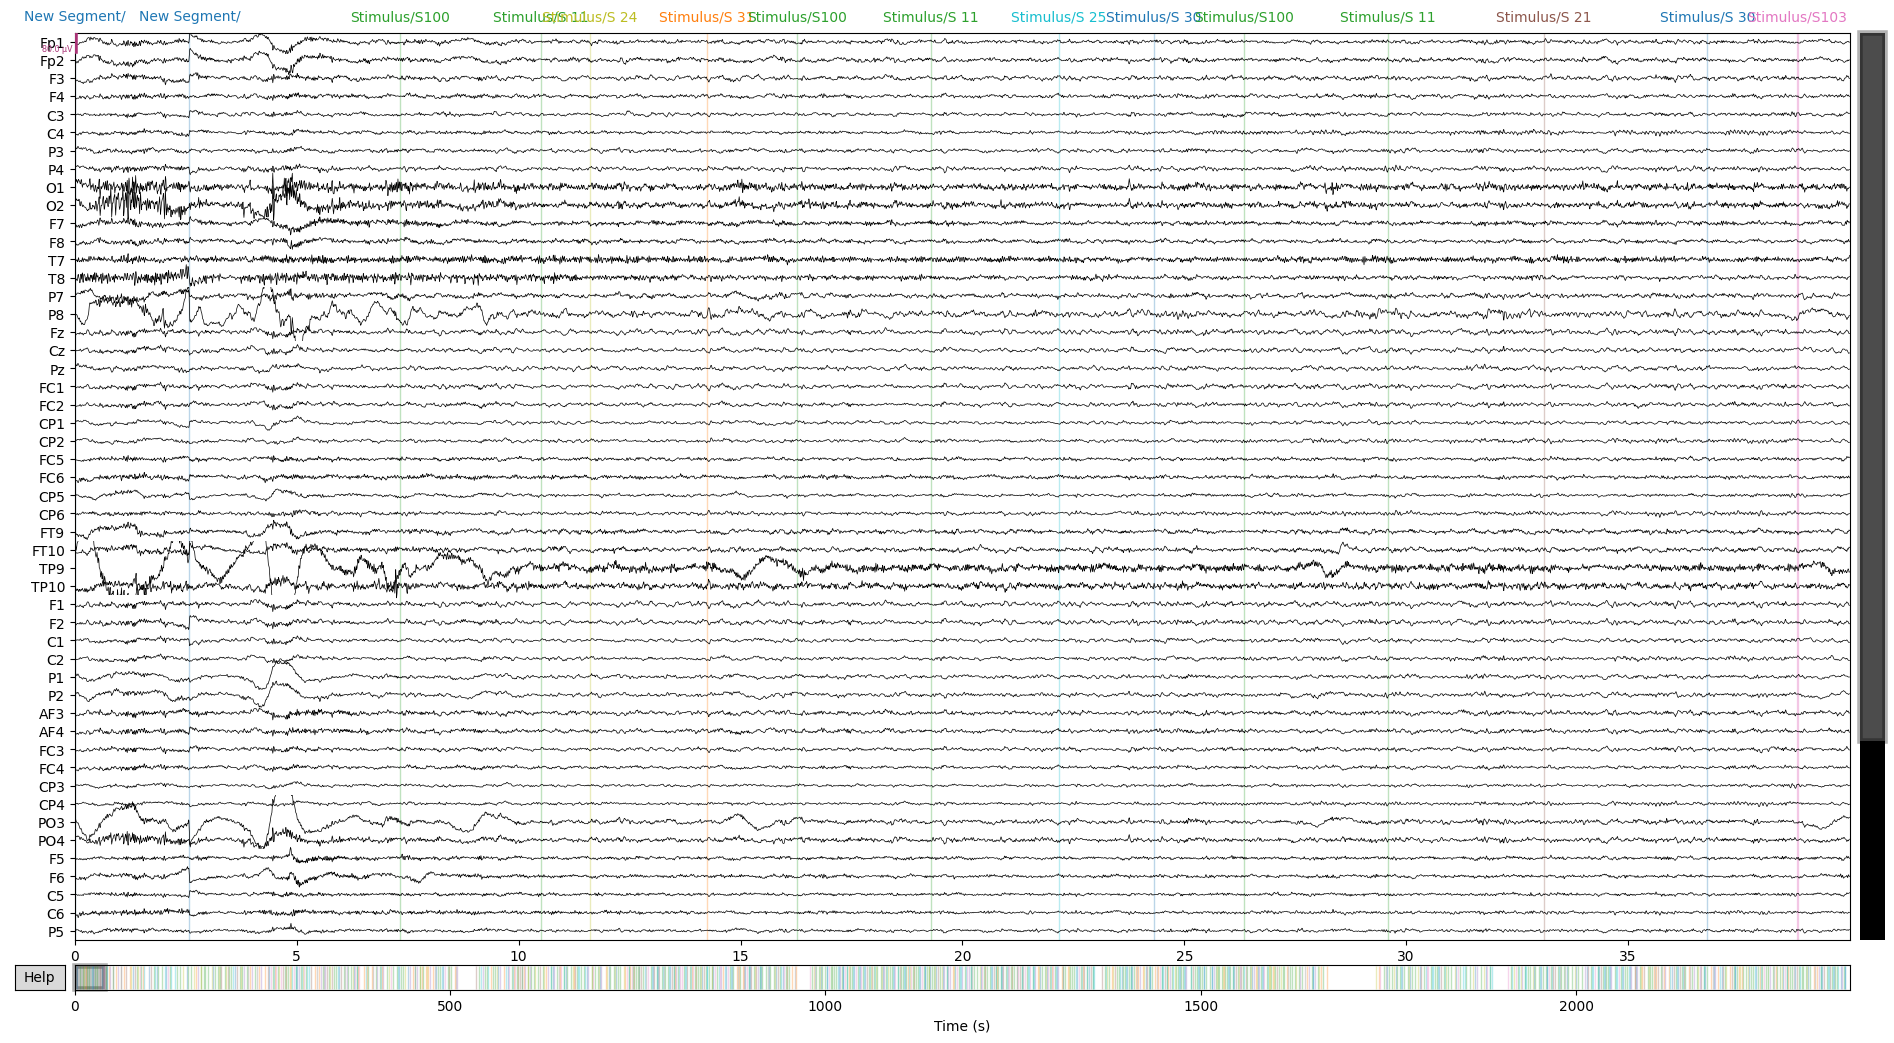

In [14]:
#自己修正一下
#如果眼电没打上的，就自己来判断成分是否是眼电成分。
#
#eog_inds = [0,1]
ica.exclude = eog_inds
ica.plot_scores(eog_scores)
#这个……在filt_raw训练出来的model，可以直接给别的数据用。。
reconst_raw =raw_filt.copy()
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)
ica.apply(reconst_raw)
reconst_raw.plot(n_channels = 50, duration =40, scalings=40e-6)

In [11]:
#确认无误，保存一下,raw ica
save_path_ica = '.\data\\4raw_ica\\'
ica.save(save_path_ica + sub_id + '.fiff')
reconst_raw.save(save_path_ica + sub_id + '.fif', overwrite=True)

Writing ICA solution to .\data\4raw_ica\prex051.fiff...
Overwriting existing file.
Writing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\4raw_ica\prex051.fif


C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_1788/3818953979.py:3: RuntimeWarning: This filename (.\data\4raw_ica\prex051.fiff) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(save_path_ica + sub_id + '.fiff')
C:\Users\SILVER~1\AppData\Local\Temp/ipykernel_1788/3818953979.py:4: RuntimeWarning: This filename (E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\4raw_ica\prex051.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  reconst_raw.save(save_path_ica + sub_id + '.fif', overwrite=True)


Closing E:\Python LYW\RSA\spaced_learning\pre10\preprocessing\data\4raw_ica\prex051.fif
[done]


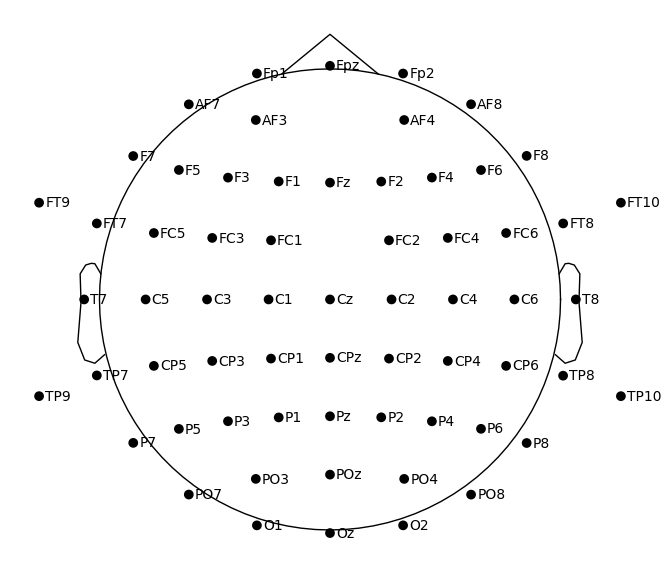

In [20]:
'''
pre10作图：脑区域图。

'''
raw.plot_sensors(show_names=True)
